<a href="https://colab.research.google.com/github/NadineML/MAML-Pytorch/blob/master/faps_maml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/naruya/maml-pytorch/find/train

# Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import io

from tqdm import tqdm
from time import sleep
from collections import OrderedDict
from more_itertools import chunked

n_shot = 2
n_class = 9
n_local_update = 5
#batch_size = n_class
batch_size = 2
#image_size = 512
#image_size = 28
#image_size = 478
image_size = 238
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [21]:
from google.colab import drive
drive.mount('/content/data')


Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


The view operation which should flatten x is throwing this error, since the size of 16*5*5 is not matching your activation size.
In the tutorial the CIFAR10 dataset is used, which has a spatial resolution of 32x32.
Most likely your custom dataset has a different spatial size, such that the view is failing.
Based on the shape given in the error message, it looks like your activation should have the shape [batch_size=4, channels=16, height=37, width=37], which results in 87616 values.
Try to change the input size if your linear layer to 16*37*37 and the flattening to:

x = x.view(x.size(0), 16*37*37)

In [3]:
class FAPSDataNet(nn.Module):
    def __init__(self, n_class):
        super(FAPSDataNet, self).__init__()
        
        self.h=64
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)

        self.conv4 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv5 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv6 = nn.Conv2d(self.h, self.h, kernel_size=3)
        #self.conv7 = nn.Conv2d(self.h, self.h, kernel_size=2)
        #self.conv8 = nn.Conv2d(self.h, self.h, kernel_size=2)

        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)

        self.bn4 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn5 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn6 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        #self.bn7 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        #self.bn8 = nn.BatchNorm2d(self.h, momentum=1, affine=True)

        self.fc = nn.Linear(self.h, n_class)
        
        # init is very very important!!!
        # no init version -> HASH:ef56239
        init.xavier_normal_(self.conv1.weight)
        init.constant_(self.conv1.bias, 0)
        init.xavier_normal_(self.conv2.weight)
        init.constant_(self.conv2.bias, 0)
        init.xavier_normal_(self.conv3.weight)
        init.constant_(self.conv3.bias, 0)

        init.xavier_normal_(self.conv4.weight)
        init.constant_(self.conv4.bias, 0)
        init.xavier_normal_(self.conv5.weight)
        init.constant_(self.conv5.bias, 0)
        init.xavier_normal_(self.conv6.weight)
        init.constant_(self.conv6.bias, 0)
        #init.xavier_normal_(self.conv7.weight)
        #init.constant_(self.conv7.bias, 0)
        #init.xavier_normal_(self.conv8.weight)
        #init.constant_(self.conv8.bias, 0)
        
        init.constant_(self.bn1.weight, 1)
        init.constant_(self.bn1.bias, 0)
        init.constant_(self.bn2.weight, 1)
        init.constant_(self.bn2.bias, 0)
        init.constant_(self.bn3.weight, 1)
        init.constant_(self.bn3.bias, 0)


        init.constant_(self.bn4.weight, 1)
        init.constant_(self.bn4.bias, 0)
        init.constant_(self.bn5.weight, 1)
        init.constant_(self.bn5.bias, 0)
        init.constant_(self.bn6.weight, 1)
        init.constant_(self.bn6.bias, 0)
        #init.constant_(self.bn7.weight, 1)
        #init.constant_(self.bn7.bias, 0)
        #init.constant_(self.bn8.weight, 1)
        #init.constant_(self.bn8.bias, 0)
        
        init.normal_(self.fc.weight, 0, 0.01)
        init.constant_(self.fc.bias, 1) # not 0 but 1.
        
    def forward(self, x):
        print("\n forward shape x: "+ str(np.shape(x))+"\n x.size(0): "+str(x.size(0)))



        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        print("\n forward shape x 1 F.max_pool2d: "+ str(np.shape(x)))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        print("\n forward shape x 2 F.max_pool2d: "+ str(np.shape(x)))
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        print("\n forward shape x 3 F.max_pool2d: "+ str(np.shape(x)))
        

        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 2)
        print("\n forward shape x 4 F.max_pool2d: "+ str(np.shape(x)))
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), 2)
        print("\n forward shape x 5 F.max_pool2d: "+ str(np.shape(x)))
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), 2)
        print("\n forward shape x 6 F.max_pool2d: "+ str(np.shape(x)))


        #a1 = self.conv7(x)
        #print("\n forward shape self.conv7(x): "+ str(np.shape(a1)))
        #b1 = self.bn7(a1)
        #print("\n forward shape self.bn7(a1): "+ str(np.shape(b1)))
        #c1 = F.relu(b1)
        #print("\n forward shape F.relu(b1): "+ str(np.shape(c1)))
        #x = F.max_pool2d(c1, 2)
        #print("\n forward shape x 7 F.max_pool2d: "+ str(np.shape(x)))


        #a = self.conv8(x)
        #print("\n forward shape self.conv8(x): "+ str(np.shape(a)))
        #b = self.bn8(a)
        #print("\n forward shape self.bn8(a): "+ str(np.shape(b)))
        #x = F.relu(b)
        #print("\n forward shape F.relu(b) "+ str(np.shape(c)))
        #x = F.max_pool2d(c, 2)
        #x = F.max_pool2d(F.relu(self.bn8(self.conv8(x))), 2)
        #print("\n forward shape x 8 F.max_pool2d: "+ str(np.shape(x)))


        x = x.view(-1, self.h)
        #x = x.view(x.size(0), self.h*62*62)
        print("\n forward shape x.view(): "+ str(np.shape(x)))
        #x = x.view(-1, self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    # for MAML local optimization
    def manual_forward(self, x, params):
        
        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn1.weight'], params['bn1.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn2.weight'], params['bn2.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn3.weight'], params['bn3.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)



        x = F.conv2d(x, params['conv4.weight'].to(device), params['conv4.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn4.weight'], params['bn4.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)

        x = F.conv2d(x, params['conv5.weight'].to(device), params['conv5.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn5.weight'], params['bn5.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)

        x = F.conv2d(x, params['conv6.weight'].to(device), params['conv6.bias'].to(device))
        dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        x = F.batch_norm(x, dumy, dumy, params['bn6.weight'], params['bn6.bias'], True, momentum=1)
        x = F.max_pool2d(F.relu(x), 2)

        #x = F.conv2d(x, params['conv7.weight'].to(device), params['conv7.bias'].to(device))
        #dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        #x = F.batch_norm(x, dumy, dumy, params['bn7.weight'], params['bn7.bias'], True, momentum=1)
        #x = F.max_pool2d(F.relu(x), 2)

        #x = F.conv2d(x, params['conv8.weight'].to(device), params['conv8.bias'].to(device))
        #dumy = torch.ones(np.prod(np.array(x.data.size()[1]))).cuda()*999999999999999999 # momentnum=1
        #x = F.batch_norm(x, dumy, dumy, params['bn8.weight'], params['bn8.bias'], True, momentum=1)
        #x = F.relu(x)
        
        x = x.view(x.size(0), self.h)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)
        
        return x

 forward shape x: torch.Size([6, 1, 512, 512])
 x.size(0): 6

 forward shape x 1 F.max_pool2d: torch.Size([6, 64, 255, 255])

 forward shape x 2 F.max_pool2d: torch.Size([6, 64, 126, 126])
Meta Test 

 forward shape x 3 F.max_pool2d: torch.Size([6, 64, 62, 62])



<ipython-input-3-9d541574005b> in forward(self, x)
     36         x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)

     37         x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)

---> 38         x = x.view(x.size(0), self.h)

     39         print("\n forward shape x.view(): "+ str(np.shape(x)))

     40         #x = x.view(-1, self.h)

RuntimeError: shape '[6, 64]' is invalid for input of size 1476096

# mit image_size = 28

Meta Test 

 forward shape x: torch.Size([9, 1, 28, 28])
 
 x.size(0): 9

 forward shape x 1 F.max_pool2d: torch.Size([9, 64, 13, 13])

 forward shape x 2 F.max_pool2d: torch.Size([9, 64, 5, 5])

 forward shape x 3 F.max_pool2d: torch.Size([9, 64, 1, 1])

 forward shape x.view(): torch.Size([9, 64])

- - - - - - - 

 forward shape x: torch.Size([3, 1, 28, 28])

 x.size(0): 3

 forward shape x 1 F.max_pool2d: torch.Size([3, 64, 13, 13])

 forward shape x 2 F.max_pool2d: torch.Size([3, 64, 5, 5])

 forward shape x 3 F.max_pool2d: torch.Size([3, 64, 1, 1])

 forward shape x.view(): torch.Size([3, 64])


 forward shape x: torch.Size([9, 1, 478, 478])
 x.size(0): 9

 forward shape x 1 F.max_pool2d: torch.Size([9, 64, 238, 238])

 forward shape x 2 F.max_pool2d: torch.Size([9, 64, 118, 118])
Meta Test 

 forward shape x 3 F.max_pool2d: torch.Size([9, 64, 58, 58])

 forward shape x 4 F.max_pool2d: torch.Size([9, 64, 28, 28])

 forward shape x 5 F.max_pool2d: torch.Size([9, 64, 13, 13])

 forward shape x 6 F.max_pool2d: torch.Size([9, 64, 5, 5])

 forward shape x 7 F.max_pool2d: torch.Size([9, 64, 2, 2])


___

RuntimeError: Given input size: (64x1x1). Calculated output size: (64x0x0). Output size is too small

-------
-------

 forward shape x: torch.Size([6, 1, 477, 477])
 x.size(0): 6

 forward shape x 1 F.max_pool2d: torch.Size([6, 64, 237, 237])

 forward shape x 2 F.max_pool2d: torch.Size([6, 64, 117, 117])

 forward shape x 3 F.max_pool2d: torch.Size([6, 64, 57, 57])

 forward shape x 4 F.max_pool2d: torch.Size([6, 64, 27, 27])

 forward shape x 5 F.max_pool2d: torch.Size([6, 64, 12, 12])

 forward shape x 6 F.max_pool2d: torch.Size([6, 64, 5, 5])

 forward shape x 7 F.max_pool2d: torch.Size([6, 64, 2, 2])

Meta Test 
 forward shape x: torch.Size([6, 1, 478, 478])
 x.size(0): 6

 forward shape x 1 F.max_pool2d: torch.Size([6, 64, 238, 238])

 forward shape x 2 F.max_pool2d: torch.Size([6, 64, 118, 118])

 forward shape x 3 F.max_pool2d: torch.Size([6, 64, 58, 58])

 forward shape x 4 F.max_pool2d: torch.Size([6, 64, 28, 28])

 forward shape x 5 F.max_pool2d: torch.Size([6, 64, 13, 13])

 forward shape x 6 F.max_pool2d: torch.Size([6, 64, 5, 5])

 forward shape self.conv7(x): torch.Size([6, 64, 4, 4])

 forward shape self.bn7(a1): torch.Size([6, 64, 4, 4])

 forward shape F.relu(b1): torch.Size([6, 64, 4, 4])

 forward shape x 7 F.max_pool2d: torch.Size([6, 64, 2, 2])

 forward shape self.conv8(x): torch.Size([6, 64, 1, 1])

 forward shape self.bn8(a): torch.Size([6, 64, 1, 1])

 forward shape F.relu(b) torch.Size([6, 64, 1, 1])


In [4]:
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for data, target in train_data_loader:
        
        data = data.to(device)  
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            
            test_loss += loss
            #test_loss += loss.item()
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

# AugmentedDataset

In [5]:
class FAPSAugmentedDataset(Dataset):
    def __init__(self, path_to_imgs, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError

        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_imgs, train_indices)):
           
            img = np.array(sorted(os.listdir(path_to_label)))
            if train:

                img = img[train_index % len(img)]
            else:
                test_index = list(set(np.arange(len(img)-1)) - set(train_index)) # mvtec modified, 15 images per defect to train
 
                img = img[test_index]
            for i in img:
                path_to_img = os.path.join(path_to_label, i)
                image = io.imread(path_to_img, as_gray=True, plugin='matplotlib')
                #print(str(path_to_img)+"  shape: "+str(np.shape(image))+"\n")
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform

    def prep(self, idx):
        img = transforms.ToPILImage()(self.data[idx][0])
        image = transforms.Resize((image_size, image_size))(img)
        self.data[idx][0] = np.array(image, np.float32)
        return self.data[idx]

    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        
        imgs = self.transform(self.prep(idx))
        return imgs

In [6]:
class ToTensor(object):
    def __call__(self, sample):
        #print("\nToTensor sample shape: " + str(np.shape(sample))+"\nsample: "+str(sample))
        image, label = sample[0], sample[1]
        #image = image / 255
        #image = (image-0.92208)/0.25140
        image = image.reshape([image_size,image_size, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

# AugmentDataLoader

In [7]:
#FAPS alternative

train_indices = np.random.randint(15, size=(n_class, n_shot))
test_indices = np.random.randint(5, size=(n_class, n_shot))

path_to_imgs = [
    "/content/data/MyDrive/modified/train/metal_nut/bent",
    "/content/data/MyDrive/modified/train/metal_nut/good",
    "/content/data/MyDrive/modified/train/metal_nut/scratch",
    "/content/data/MyDrive/modified/train/screw/good",
    "/content/data/MyDrive/modified/train/screw/manipulated_front",
    "/content/data/MyDrive/modified/train/screw/scratch_head",
    "/content/data/MyDrive/modified/train/screw/scratch_neck",
    "/content/data/MyDrive/modified/train/screw/thread_side",
    "/content/data/MyDrive/modified/train/screw/thread_top"
]


local_task_train_data


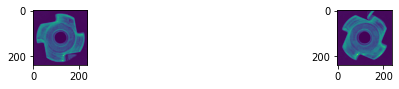

y_true: tensor([0, 0])


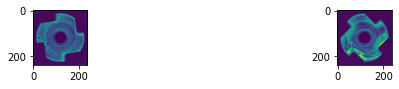

y_true: tensor([1, 1])


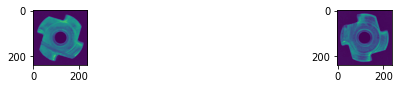

y_true: tensor([2, 2])


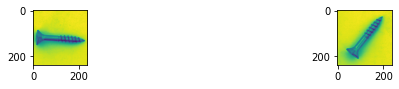

y_true: tensor([3, 3])


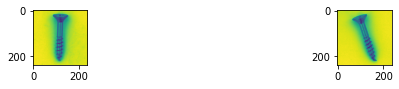

y_true: tensor([4, 4])


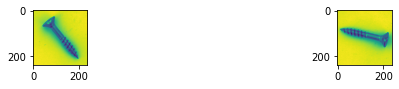

y_true: tensor([5, 5])


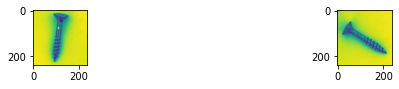

y_true: tensor([6, 6])


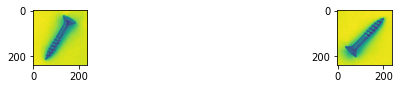

y_true: tensor([7, 7])


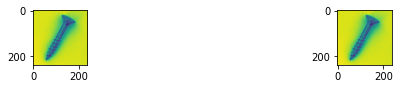

y_true: tensor([8, 8])

local_task_test_data


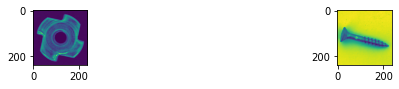

y_true: tensor([1, 6])


In [8]:
#new
print("local_task_train_data")

train_data_transform = transforms.Compose(
        [
            ToTensor()
        ]
)


local_task_train_data_loader = DataLoader(
    FAPSAugmentedDataset(path_to_imgs,
                    train=True,
                    train_indices=train_indices,
                    transform=train_data_transform),
    batch_size=batch_size, shuffle=False)


for data in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    target = data[1]
    for i, x in enumerate(data[0]):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

print("\nlocal_task_test_data")
local_task_test_data_loader = DataLoader(
    FAPSAugmentedDataset(path_to_imgs,
                    train=False,
                    train_indices=test_indices,
                    transform=train_data_transform),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break

# Taskset and TaskLoader classes

In [9]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return len(self.taskset)

In [10]:
dev = torch.cuda.current_device()
torch.cuda.list_gpu_processes(device=dev)


'GPU:0\nno processes are running'

# AugmentedTaskset

In [11]:
class FAPSAugmentedTaskset(Taskset):
    def __init__(self, path_to_data, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_data, "train")
        else:
            path_to_langs = os.path.join(path_to_data, "test")
            
        imgs = []
        '''
        for path_to_lang in os.listdir(path_to_langs):
            path_to_imgs = os.path.join(path_to_langs, path_to_lang)
            for path_to_img in os.listdir(path_to_imgs):
                imgs.append(os.path.join(path_to_imgs, path_to_img)) 
        
        random.shuffle(imgs)
        tasks = list(chunked(imgs, n_class))[:-1] # drop_last
        '''
        #code von ria?
        data = sorted(os.listdir(path_to_langs))
        categories = [os.path.join(path_to_langs, d) for d in data]
        subcategories = [os.listdir(task) for task in categories]

        tasks = [[os.path.join(categories[s],task) for task in subcategories[s]] for s in range(len(categories))]

        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_indices = np.random.randint(15, size=(n_class, n_shot))
        test_indices = np.random.randint(5, size=(n_class, n_shot))
        return {"train":
                DataLoader(
                    FAPSAugmentedDataset(self.tasks[idx],
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        #transforms.ToPILImage(),
                                        #transforms.Resize(image_size),
                                        #transforms.Grayscale(num_output_channels=1),                          
                                        #transforms.Resize((image_size, image_size)),
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    FAPSAugmentedDataset(self.tasks[idx],
                                    train=False,
                                    train_indices=test_indices,
                                    transform=transforms.Compose([
                                        #transforms.ToPILImage(),
                                        #transforms.Resize(image_size),
                                        #transforms.Grayscale(num_output_channels=1),
                                        #transforms.Resize((image_size, image_size)),
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

# AugmentTaskLoader

In [12]:
#FAPS alternative

meta_train_task_loader = TaskLoader(
    FAPSAugmentedTaskset("/content/data/MyDrive/modified", meta_train=True, n_class=n_class, n_shot=n_shot)
)


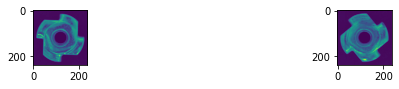

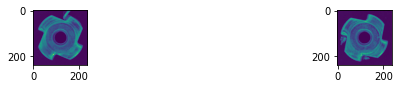

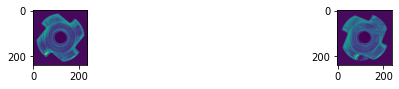

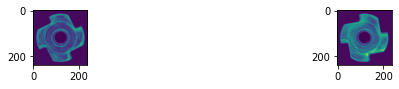

In [13]:
for i, meta_train_task in enumerate(meta_train_task_loader):
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
    local_task_test_data_loader = meta_train_task["test"]
    for data, target in local_task_test_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        break
    break

# MAML

In [14]:
class FAPSMetaLearner(object):
    def __init__(self):
        self.lr = 0.1
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = FAPSDataNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def save(self, model_path):
        torch.save(self.master_net.state_dict(), model_path)
    
    def load(self, model_path):
        self.master_net.load_state_dict(torch.load(model_path))
    
    def meta_test(self):
        taskset = FAPSAugmentedTaskset("/content/data/MyDrive/modified", meta_train=False, n_class=n_class, n_shot=n_shot)
        meta_test_task_loader = TaskLoader(taskset)

        test_loss, test_acc = [], [] # For logging.
        
        sleep(0.5)



        with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
            for meta_test_task in _tqdm:

                # copy master model to new branch model
                faster_net = FAPSDataNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)
                faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)

                # make local task data loader
                local_task_train_data_loader = meta_test_task["train"]
                local_task_test_data_loader = meta_test_task["test"]

                # ----------------------------------------------------------------
                # meta test task train
                # ----------------------------------------------------------------

                for epoch in range(n_local_update):

                    _train_loss, _train_acc = train(
                        faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                # ----------------------------------------------------------------
                # meta test task test
                # ----------------------------------------------------------------

                _test_loss, _test_acc = test(faster_net, self.device, local_task_test_data_loader)
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)

        #print("\ntest loss: "+ str(test_loss))
        #print("\ntest acc: "+ str(test_acc))
        return np.mean(test_loss), np.mean(test_acc)

    
    def meta_train(self):
        meta_train_task_loader = TaskLoader(
            FAPSAugmentedTaskset("/content/data/MyDrive/modified", meta_train=True, n_class=n_class, n_shot=n_shot))
    
        meta_grads = []
        
        test_loss, test_acc = [], [] # For logging.
        
        sleep(0.5)
        with tqdm(meta_train_task_loader, desc="Meta Train", ncols=10) as _tqdm:

            for meta_train_task in _tqdm:

                
                # copy master model to new branch model
                faster_net = FAPSDataNet(n_class).to(self.device)
                faster_net.forward = NotImplementedError # goodbye!
                self.copy_params(self.master_net, faster_net)

                # faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())
                master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())

                # make local task data loader
                local_task_train_data_loader = meta_train_task["train"]
                local_task_test_data_loader = meta_train_task["test"]

                # ----------------------------------------------------------------
                # meta train task train
                # ----------------------------------------------------------------

                first_train_for_this_task = True

                for epoch in range(n_local_update):
                    
                    _train_loss = 0 # For tqdm.
                    _train_acc = 0 # For tqdm.
                    
                    for data, target in local_task_train_data_loader:
                        data, target = data.to(self.device), target.to(self.device)

                        if first_train_for_this_task:
                            # manual predict
                            output = self.master_net(data)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            #_train_loss += loss.item()
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                            
                            grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                            faster_params = OrderedDict(
                                (name, param - self.lr*grad)
                                for ((name, param), grad) in zip(master_params.items(), grads)
                            )
   
                            first_train_for_this_task = False

                        else:
                            # manual predict
                            output = faster_net.manual_forward(data, faster_params)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            #_train_loss += loss.item()
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                                                        
                            grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)

                            faster_params = OrderedDict(
                                (name, param - self.lr*grad)
                                for ((name, param), grad) in zip(faster_params.items(), grads)
                            )
                            ####


                        #test        
                        #data.detach()



                    _train_loss /= len(local_task_train_data_loader.dataset)
                    _train_acc /= len(local_task_train_data_loader.dataset)
                    
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                
                # ----------------------------------------------------------------
                # meta train task test
                # ----------------------------------------------------------------
                
                _test_loss = 0 # For logging.
                _test_acc = 0 # For logging.
                
                for data, target in local_task_test_data_loader:
                    
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)
                    loss = F.nll_loss(output, target) # test_loss計算するとこまではfaster_net

                    # differentiates test_loss by master_net params
                    grads = torch.autograd.grad(loss, self.master_net.parameters(), retain_graph=True)
                    grads = {name:g for ((name, _), g) in zip(faster_net.named_parameters(), grads)}
                    meta_grads.append(grads)

                    pred = output.max(1, keepdim=True)[1]
                    acc = pred.eq(target.view_as(pred)).sum()
                    
                    _test_loss += loss.item()
                    _test_acc += acc.item()
                
                _test_loss /= len(local_task_test_data_loader.dataset)
                _test_acc /= len(local_task_test_data_loader.dataset)  
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
                
        
        # ----------------------------------------------------------------
        # end all tasks
        # ----------------------------------------------------------------
        
        # ----------------------------------------------------------------
        # meta update
        # ----------------------------------------------------------------
        
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}
        
        # using data,target from somewhere
        dumy_output = self.master_net(data)
        dumy_loss = F.nll_loss(dumy_output, target)
        
        # after dumy_loss.backward, rewrite grads
        self.master_opt.zero_grad()
        dumy_loss.backward(retain_graph=True)

        hooks = []
        for (k,v) in self.master_net.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return meta_grads[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))

        # Compute grads for current step, replace with summed gradients as defined by hook
        self.master_opt.zero_grad()
        dumy_loss.backward()

        # Update the net parameters with the accumulated gradient according to optimizer
        self.master_opt.step()

        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

        return np.mean(test_loss), np.mean(test_acc)  

In [15]:
#FAPS alternative
meta_learner = FAPSMetaLearner()


In [16]:
mem = torch.cuda.memory_summary(device=None, abbreviated=False)
print(mem)
torch.cuda.empty_cache()
dev = torch.cuda.current_device()
torch.cuda.list_gpu_processes(device=dev)


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  761344 B  |  761344 B  |  761344 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |  761344 B  |  761344 B  |  761344 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  761344 B  |  761344 B  |  761344 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

'GPU:0\nprocess      26284 uses      514.375 MB GPU memory'

In [17]:
# see normal few-shot learning
for _ in range(2):
    test_loss, test_acc = meta_learner.meta_test()
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        0, test_loss, test_acc))



Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64]

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23


Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

# trouble

In [18]:
mem = torch.cuda.memory_summary(device=None, abbreviated=False)
print(mem)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  761344 B  |  126318 KB |   77653 MB |   77653 MB |
|       from large pool |       0 B  |  122834 KB |   75625 MB |   75625 MB |
|       from small pool |  761344 B  |    6538 KB |    2028 MB |    2027 MB |
|---------------------------------------------------------------------------|
| Active memory         |  761344 B  |  126318 KB |   77653 MB |   77653 MB |
|       from large pool |       0 B  |  122834 KB |   75625 MB |

In [19]:
dev = torch.cuda.current_device()
torch.cuda.list_gpu_processes(device=dev)


'GPU:0\nprocess      26284 uses      711.375 MB GPU memory'

In [23]:
for epoch in range(3):
    
    train_loss, train_acc = meta_learner.meta_train()
    test_loss, test_acc = meta_learner.meta_test()
    
    print("# {} (meta-train-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, train_loss, train_acc))    
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, test_loss, test_acc))
    
    model_path = "/content/data/MyDrive/modified/model/model-epoch_{:05}-train_loss_{:0.3f}-train_acc_{:0.3f}-test_loss_{:0.3f}-test_acc_{:0.3f}.pt".format(
        epoch, train_loss, train_acc, test_loss, test_acc)
    
    meta_learner.save(model_path)
#     meta_learner.load(model_path)

Meta Train


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Train


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Train



 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([1, 1, 238, 238])
 x.size(0): 1

 forward shape x 1 F.max_pool2d: torch.Size([1, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([1, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([1, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([1, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([1, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([1, 64, 1, 1])

 forward shape x.view(): torch.Size([1, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])
# 1 (meta-train-task) test_loss: 0.669656, t


Meta Train


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Train


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Train



 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size

Meta Test 


 forward shape x 2 F.max_pool2d: torch.Size([1, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([1, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([1, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([1, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([1, 64, 1, 1])

 forward shape x.view(): torch.Size([1, 64])


Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([1, 1, 238, 238])
 x.size(0): 1

 forward shape x 1 F.max_pool2d: torch.Size([1, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([1, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([1, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([1, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([1, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([1, 64, 1, 1])

 forward shape x.view(): torch.Size([1, 64])
# 2 (meta-train-task) test_loss: 0.835610, test_acc: 0.433782
# 2  (meta-test-task) test_loss: 2.964856, test_acc: 0.182165



Meta Train


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Train


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Train



 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])


Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 238])
 x.size(0): 2

 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([2, 1, 238, 23

Meta Test 


 forward shape x 1 F.max_pool2d: torch.Size([2, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([2, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([2, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([2, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([2, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([2, 64, 1, 1])

 forward shape x.view(): torch.Size([2, 64])

 forward shape x: torch.Size([1, 1, 238, 238])
 x.size(0): 1

 forward shape x 1 F.max_pool2d: torch.Size([1, 64, 118, 118])

 forward shape x 2 F.max_pool2d: torch.Size([1, 64, 58, 58])

 forward shape x 3 F.max_pool2d: torch.Size([1, 64, 28, 28])

 forward shape x 4 F.max_pool2d: torch.Size([1, 64, 13, 13])

 forward shape x 5 F.max_pool2d: torch.Size([1, 64, 5, 5])

 forward shape x 6 F.max_pool2d: torch.Size([1, 64, 1, 1])

 forward shape x.view(): torch.Size([1, 64])
# 3 (meta-train-task) test_loss: 1.414454, test_acc: 0.124960
# 3  (meta-test-task) test_loss: 3.260809, t

In [24]:
dev = torch.cuda.current_device()
torch.cuda.list_gpu_processes(device=dev)

'GPU:0\nprocess      26284 uses     6507.375 MB GPU memory'